In this project, we are using Airbnb dataset in Seattle, WA. This dataset describes the listing activity of homestays in Seattle, WA.

In [295]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import datetime as dt
from time import time

from itertools import chain

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error,fbeta_score,accuracy_score, make_scorer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.grid_search import GridSearchCV

%matplotlib inline

### Step 0: Load the Data

There are 3 files in this project:

- calendar: including listing id and the price and availability for that day; 1.39m rows * 4 columns
- listing:  including full descriptions and average review score;
3,819 rows * 92 columns
- reviews:  including unique id for each reviewer and detailed comments;
84.8k rows * 6 columns

In [296]:
# load in the calendar data
calendar_01 = pd.read_csv('calendar.csv')
# load in the listing data
listings = pd.read_csv('listings.csv')
# load in the reviews data
reviews = pd.read_csv('reviews.csv')

In [297]:
# print the first few rows in the calendar dataset
calendar_01.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [298]:
# print the first few rows in the listings dataset
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [299]:
# print the first few rows for reviews
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


### Step 1: Preprocessing

#### Step 1.1: Assess Missing Data

The listings file including full descriptions and average review score. I will use this this file to find the answer for the first question. 

- What is the vibe of each Seattle neighborhood using listing descriptions?

First of all, I will access the listing data in terms of missing data.

#### Step 1.1.1: Assess Missing Data in Each columns


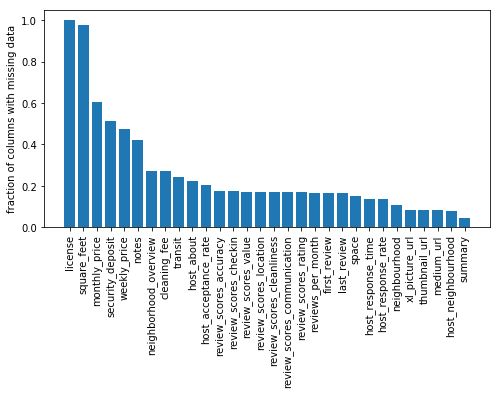

In [300]:
# Perform an assessment of how much missing data there is in each column of the 
# data set
plt.figure(figsize=(8,4))
na_counts_col = listings.isna().sum().sort_values(ascending = False) / listings.shape[0]

# we ignore the columns with the number of missing values less than 1%
na_counts_col = na_counts_col[na_counts_col > 0.01]


plt.xticks(np.arange(len(na_counts_col)), na_counts_col.index, rotation = 'vertical')
plt.ylabel('fraction of columns with missing data')
plt.bar(np.arange(len(na_counts_col)), na_counts_col);

#### Discussion 1.1.1: Assess Missing Data in Each Column
columns 'license' and 'square feet' have missing values for most the rows. Thus, we decide to drop the two columns.

In [301]:
# Remove the outlier columns from the dataset
columns_to_drop = ['license', 'square_feet']
listings.drop(columns_to_drop, axis = 1, inplace = True)

#### Step 1.1.2: Assess Missing Data in Each Row

At this part, I will perform a similar assessment for the rows of the dataset. How much data is missing in each row? And I will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I will check the distribution of data values on columns that are not missing data(or are missing very little data) are similar or different between the two groups. I will select five of these columns and compare the distribution of values.

In [302]:
# Calculate the fraction of missing data in each row
row_index = listings.index.values
na_count_row = listings.isnull().sum(axis = 1)
listings['na_count'] = na_count_row
listings['na_count'].describe()

count    3818.000000
mean        5.835516
std         5.556406
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        31.000000
Name: na_count, dtype: float64

Text(0.5,0,'number of missing values in each row')

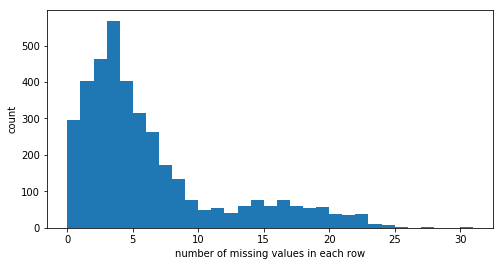

In [303]:
# Perform an assessment of how much missing data there is in each row of the 
# data set
plt.figure(figsize=(8,4))
na_count_row = pd.DataFrame(na_count_row)
na_count_row.rename(index = str, columns = {0:"na_count"}, inplace = True)
na_count_row.head()

bin_edges = np.arange(0,32,1)
plt.hist(data = na_count_row, x = 'na_count',bins = bin_edges)

plt.ylabel('count')
plt.xlabel('number of missing values in each row')

In [304]:
# Compare the distribution of values for at least five columns 
# where are no or few missing values between the subset

# Check columns without missing values
'''
test = listings.isna().sum().sort_values(ascending = True)
test[test == 0]
# select five columns without missing values
# price
# neighbourhood_cleansed
# minimum nights
# number_of_reviews
# calculated_host_listings_count

'''
selected_cols = ['price', 'neighbourhood_cleansed', 'minimum_nights',
                 'number_of_reviews', 'calculated_host_listings_count']

# convert 'price','weekly_price', 'monthly_price','security_deposit', 'cleaning_fee', 'extra_people' from string to float
price_cols_list = ['price','weekly_price', 'monthly_price','security_deposit', 'cleaning_fee', 'extra_people']
for col in price_cols_list:
    listings[col] = listings[col].replace('[\$,]','',regex = True).astype(float)



In [305]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
Threshold = 7
listings_above = listings[listings['na_count'] >= Threshold]
listings_below = listings[listings['na_count'] < Threshold]

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:10

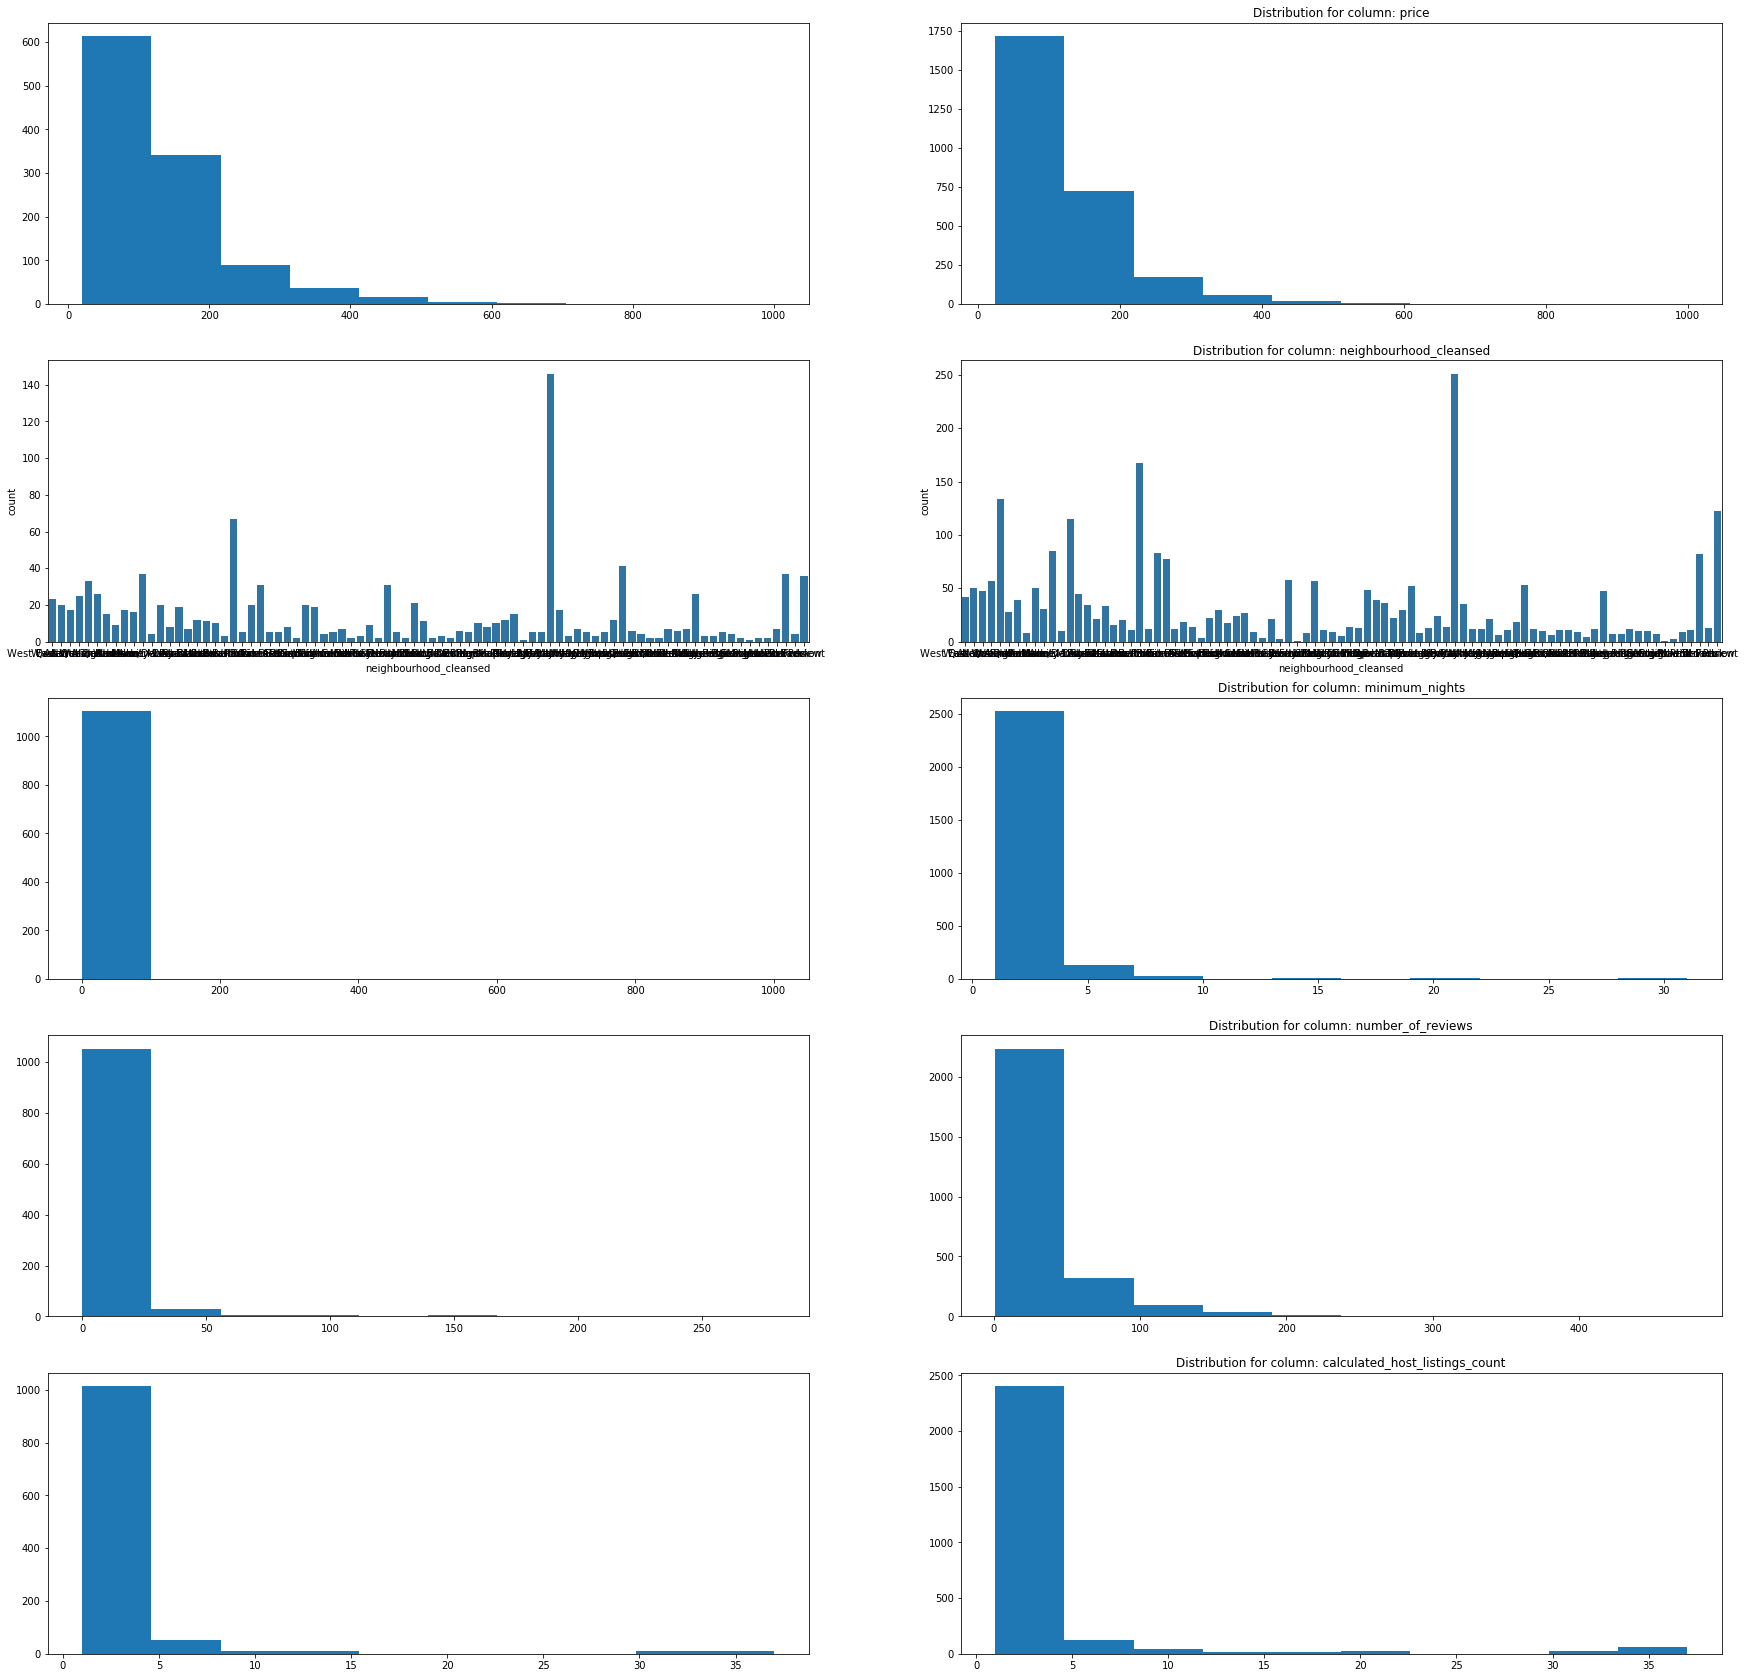

In [306]:
plt.figure(figsize=(30,30))

for i, col in enumerate(selected_cols):
    plt.subplot(5,2,i+1)
    if col == "neighbourhood_cleansed": # using countplot to plot qualitive variables
        base_color = sns.color_palette()[0]
        plt.subplot(5,2,i*2+1)
        sns.countplot(data = listings_above, x = col, color = base_color);
        plt.subplot(5,2,i*2+2)
        sns.countplot(data = listings_below, x = col, color = base_color);
    else: # using hist to plot quantative variables
        plt.subplot(5,2,i*2+1)
        plt.hist(data = listings_above,x = col, label = 'above');
        plt.subplot(5,2,i*2+2)
        plt.hist(data = listings_below,x = col, label = 'below');        
    plt.title('Distribution for column: {}'.format(col))
    plt.legend


The largest number of missing values for a row is 31. The 75% percentile number of missing value in rows is 7. After setting 7 as threshold and selecting five rows to check the distribution between the subset above threshold and the subset below the threshold. We find the distribution is similar and we conlcude that
1. The data with lots of missing values are not qualittively different from data with few or no missing values.
2. Dropping those points from the analysis won't present a major issue.

So we will use the subset which has less than 7 number of missing values in each row.


### Step 1.2: Select and Re-Encode Features

In this part, we will perform an investigation of the features

- For numeric and interval data, these features can be kept without changes
- For country, city and latitute geography information, since the data is from Seattle, the data is same for most rows, I will drop the data.
- For amenities, text features such as summary, notes, I choose to drop due to the complexity for analysing the data.
- For id, name and url information, since the value does not not provide any useful information, I will drop the data.
- Convert 'host_acceptance_rate'and 'host_response_rate' from string to float
- Convert 'host_has_profile_pic', 'instant_bookable', 'host_identity_verified', 'is_location_exact', 'require_guest_profile_picture', 'require_guest_phone_verification','host_is_superhost' from string t/f to dummy variable 1/0
- Drop columns 'host_total_listings_count' because the column is same as 'host_listings_count'
- For missing price in below columns,given no missing value in column 'price', we apply below formula to fillin nan
    - monthly_price   =     mean(monthly_price / price) * price
    - weekly_price    =     mean(weekly_price / price) * price
    - security_deposit =     mean(security_deposit / price) * price
    - cleaning_fee    =     mean(cleaning_fee / price) * price

In [307]:
# choose the dataset below the threshold
df = listings_below

# features with constant values
cons_cols = [ 'has_availability', 'experiences_offered', 'last_scraped','calendar_last_scraped']
df_no_cons_cols = df.drop(cons_cols,axis = 1)

# text features
txt_cols = ['summary','space','description', 'neighborhood_overview',
            'notes','transit','host_about','amenities']
df_no_txt_cols = df_no_cons_cols.drop(txt_cols,axis = 1)

# columns with city and above level geography information
geo_cols = ['city', 'state', 'zipcode', 'market','country_code', 'country']
df_no_geo_cols = df_no_txt_cols.drop(geo_cols,axis = 1)

# columns with names
name_cols = [col for col in df.columns if 'name' in col]
df_no_name_cols = df_no_geo_cols.drop(name_cols,axis = 1)

# columns with id
id_cols = [col for col in df.columns if col[-2:] == 'id']
df_no_ids = df_no_name_cols.drop(id_cols,axis = 1)

# columns with url
url_cols = [col for col in df.columns if 'url' in col]
df_no_url_cols = df_no_ids.drop(url_cols,axis = 1)


In [308]:
# covert host_acceptance_rate, 'host_response_rate' and respon from sting to float
df_acceptance_rate = df_no_url_cols.copy()
cols_percent = ['host_acceptance_rate', 'host_response_rate']
for col in cols_percent:
    df_acceptance_rate[col] = df_acceptance_rate[col].str.rstrip('%').astype(float)/100

In [309]:
# convert host_has_profile_pic, host_identity_verified, instant_bookable, host_identity_verified
# is_location_exact, require_guest_profile_picture, require_guest_phone_verification, 
# host_is_superhost from string t/f to dummy variable 1/0

dummy_cols_list = ["host_has_profile_pic", "instant_bookable","is_location_exact","require_guest_profile_picture",
                   "require_guest_phone_verification","host_is_superhost","host_identity_verified"]

df_dummy_cols = df_acceptance_rate.copy()

for col in dummy_cols_list:
    df_dummy_cols[col].replace('t',1, inplace = True)
    df_dummy_cols[col].replace('f',0, inplace = True)

# drop requires_license since all rows are same value 'f'
df_requires_license =  df_dummy_cols.copy()
df_requires_license.drop('requires_license', axis = 1, inplace = True)

In [310]:
# drop columns 'host_total_listings_count' because the column is same as ;host_listings_count
df_drop_host_total_listing_count = df_requires_license.drop('host_total_listings_count', axis = 1)

In [311]:
# for missing price in below columns
# we use average ratio of the other not missing rows divided by price times 'price' in the missing row to fillin nan
missing_price_cols = ["monthly_price","security_deposit","weekly_price","cleaning_fee"]
df_fillna_price = df_drop_host_total_listing_count.copy()

for col in missing_price_cols:
    price_ratio = (df_fillna_price[col]/df_fillna_price['price']).mean()  
    df_fillna_price[col][df_fillna_price[col].isnull()] = price_ratio * df_fillna_price['price'][df_fillna_price[col].isnull()]


    

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [312]:
# drop rows contain missing values
df_dropna = df_fillna_price.dropna(axis = 0)

In [313]:
# final data set for analysing and modelling
df_final = df_dropna.copy()

### Qn1 What features determine the price

In this part, we will apply linear regression.
Before applying the model, we will perform below procedure in order to use the linear regression:

- transform date type data 'host_since' to number of days
- remove the features do not relate to the price
- create one hot encoding columns for categorical data

In [314]:
# transform quality data 'host_repsonse_time' to quantitative order data
df_host_response_time = df_final.copy()
df_host_response_time['host_response_time'].replace('within an hour',4, inplace = True)
df_host_response_time['host_response_time'].replace('within a few hours',3, inplace = True)
df_host_response_time['host_response_time'].replace('within a day',2, inplace = True)
df_host_response_time['host_response_time'].replace('a few days or more',1, inplace = True)

In [315]:
# convert 'host_since', 'first_review', 'last_review' to number of days
cols_date = ['host_since', 'first_review', 'last_review']
df_days = df_no_url_cols.copy()
for col in cols_date:
    col_name = col + "_days"
    host_since = df_no_url_cols[col].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date())
    host_days = dt.date(2016,1,4) - host_since
    df_host_response_time[col_name] = host_days.dt.days
    df_host_response_time.drop(col,axis = 1,inplace = True)

In [316]:
# we would like to use neighbourhoud_group_cleased to store the neighborhood information
# thus, we would like to drop othe features which related to neighorhood
neighborhood_features = ['host_neighbourhood','neighbourhood_cleansed','street','neighbourhood']
df_neighborhood = df_host_response_time.drop(neighborhood_features, axis = 1).copy()

In [317]:
scaler = MinMaxScaler()
numerical_col = ['host_listings_count','calculated_host_listings_count',
                 'price','weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee','extra_people',
                 'availability_30', 'availability_60', 'availability_90','availability_365', 
                 'number_of_reviews','reviews_per_month',
                 'host_since_days', 'first_review_days', 'last_review_days']
df_minmax_transform = pd.DataFrame(data = df_neighborhood).copy()
df_minmax_transform[numerical_col] = scaler.fit_transform(df_minmax_transform[numerical_col])

In [318]:
# To simplify our analysis and reduce uncessary features
# we will remove below features do not contribute to the price by business understanding
df_clean_nonsense_col = df_minmax_transform.drop(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                                    'host_verifications','host_location','smart_location', 
                                    'host_listings_count', 'host_has_profile_pic',
                                    'calendar_updated', 'cancellation_policy',
                                    'latitude','longitude', 'is_location_exact',
                                    'weekly_price', 'monthly_price', 'security_deposit', 'na_count'], axis = 1)

In [319]:
# Create dummy columns for all the categorical variables, drop the original columns
df_dummy = pd.get_dummies(df_clean_nonsense_col)

In [320]:
# Create X as all the columns other than price
X = df_dummy.drop(['price'], axis = 1)
# Create y as the price column
y = df_dummy['price']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# show the results of split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1784 samples.
Testing set has 446 samples.


In [321]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
    Inputs:
    - Learner: the learning algorithm to be trained and predicted on
    - Sample_size: the size of samples (number) to be drawn from training set
    - X_train: features training set
    - y_train: price training set
    - X_test: features testing set
    - y_test: price testing set
    '''
    
    results = {}
    
    # fit the learner to the training data using slicing with 'sample_size' 
    start = time()
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time()
    
    # Calculate the training time
    results['train_time'] = end - start
    
    # Get the predictions on the test set X_test
    predictions_test = learner.predict(X_test)
    


    # Compuate r squared on test set using accuracy_score()
    results['r2_test'] = r2_score(y_test, predictions_test)
    
    
    # Compute mean absolute error on the test set which is y_test
    results['mae_test'] = mean_absolute_error(y_test,predictions_test)
    
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    return results

In [322]:
# Initialize the linear model
lm = LinearRegression()


results = {}
lm_name = lm.__class__.__name__
results[lm_name] = train_predict(lm,len(y_train), X_train, y_train, X_test, y_test)

# Report the before-and-afterscores
print("\nLinear Regression Model\n------")
print("r2 score on testing data: {:.4f}".format(results['LinearRegression']['r2_test']))
print("mean absolute error on testing data: {:.4f}".format(results['LinearRegression']['mae_test']))

LinearRegression trained on 1784 samples.

Linear Regression Model
------
r2 score on testing data: 0.6001
mean absolute error on testing data: 0.0324


In [323]:
# coefficient analysis
features_coef = pd.DataFrame(lm.coef_)
features_coef.index = X.columns
features_coef.rename(index = str, columns = {0:'coef'},inplace = True)
features_coef['abs_coef'] = np.absolute(features_coef['coef'])
features_coef.sort_values(by = ['abs_coef'], ascending = False)

,coef,abs_coef
property_type_Boat,0.411878,0.411878
cleaning_fee,0.170700,0.170700
last_review_days,0.051727,0.051727
property_type_Dorm,-0.046801,0.046801
property_type_Camper/RV,-0.046721,0.046721
property_type_Bed & Breakfast,-0.043734,0.043734
property_type_Apartment,-0.039279,0.039279
property_type_Townhouse,-0.038832,0.038832
property_type_House,-0.036691,0.036691
property_type_Other,-0.034557,0.034557


From above, we can see below features have significant impace on the price:

- neighbourhood_group_cleansed
- property_type
- room_type
- bathrooms

Moving on, we will frist visualize the average price in different neighbourhoods.
And then, we will check whether the price difference can be explained by property_type, room_type, and bathrooms.

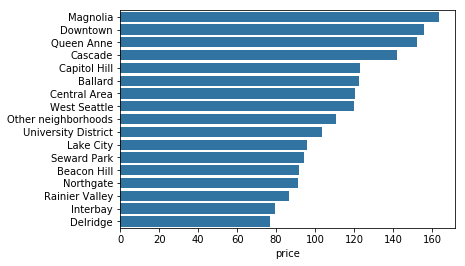

In [324]:
# plot the average price group by property_type

df_plot_neigh = df_neighborhood[['neighbourhood_group_cleansed','price' ]].groupby(['neighbourhood_group_cleansed']).mean().sort_values(by = ['price'], ascending = False)
base_color = sns.color_palette()[0]
sns.barplot(y = df_plot_neigh.index.values,x =  df_plot_neigh['price'], color = base_color);
neigh_level_order = df_plot_neigh.reset_index(level = 0).reset_index(level = 0)['neighbourhood_group_cleansed'].values
ordered_cat_neigh = pd.api.types.CategoricalDtype(ordered = True, categories = neigh_level_order)

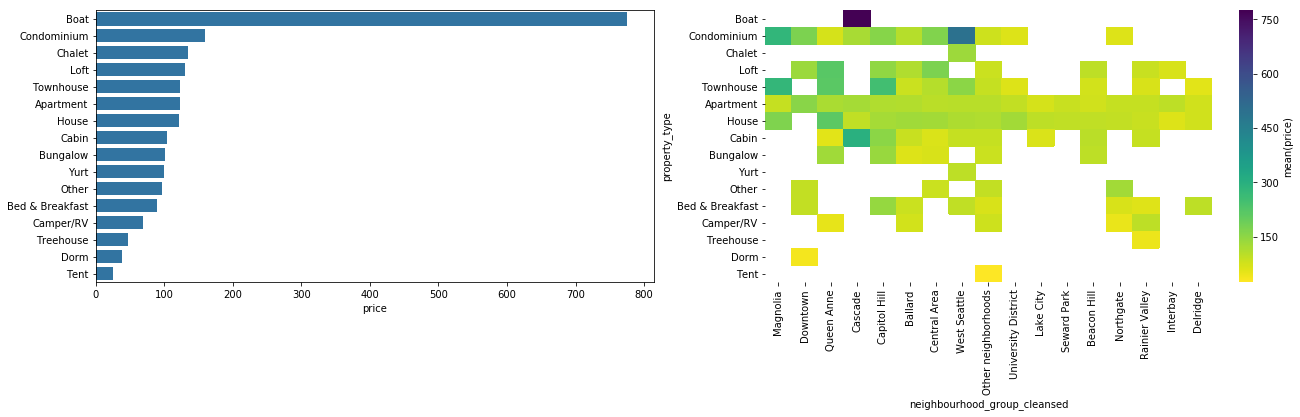

In [325]:
plt.figure(figsize = [22, 5])
# plot the average price group by property_type
plt.subplot(1,2,1)
df_plot_property = df_neighborhood[['property_type','price' ]].groupby(['property_type']).mean().sort_values(by = ['price'], ascending = False)
base_color = sns.color_palette()[0]
sns.barplot(y = df_plot_property.index.values,x =  df_plot_property['price'], color = base_color);
property_level_order = df_plot_property.reset_index(level = 0).reset_index(level = 0)['property_type'].values
ordered_cat_property = pd.api.types.CategoricalDtype(ordered = True, categories = property_level_order)

plt.subplot(1,2,2)
# plot the average price group by property_type and neighbours
df_temp_01 = df_neighborhood.copy()
df_temp_01['property_type'] = df_temp_01['property_type'].astype(ordered_cat_property)
df_temp_01['neighbourhood_group_cleansed'] = df_temp_01['neighbourhood_group_cleansed'].astype(ordered_cat_neigh)
cat_means = df_temp_01.groupby(['neighbourhood_group_cleansed',  'property_type']).mean()['price']
cat_means = cat_means.reset_index(name = 'price_avg')
cat_means = cat_means.pivot(index = 'property_type', columns = 'neighbourhood_group_cleansed',
                            values = 'price_avg')

sns.heatmap(cat_means, annot = False, fmt = '.3f',cmap='viridis_r', cbar_kws = {'label' : 'mean(price)'})

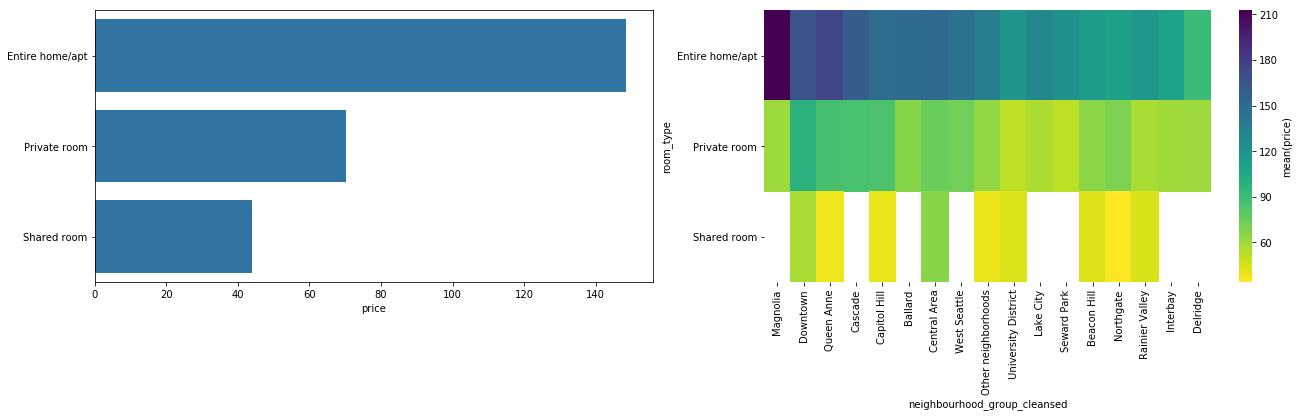

In [326]:
plt.figure(figsize = [22, 5])
# plot the average price group by room_type
plt.subplot(1,2,1)

df_plot_room = df_neighborhood[['room_type','price' ]].groupby(['room_type']).mean().sort_values(by = ['price'], ascending = False)
base_color = sns.color_palette()[0]
sns.barplot(y = df_plot_room.index.values,x =  df_plot_room['price'], color = base_color);
room_level_order = df_plot_room.reset_index(level = 0).reset_index(level = 0)['room_type'].values
ordered_cat_room = pd.api.types.CategoricalDtype(ordered = True, categories = room_level_order)

plt.subplot(1,2,2)
# plot the average price group by room_type and neighbour

df_temp_02 = df_neighborhood.copy()
df_temp_02['room_type'] = df_temp_02['room_type'].astype(ordered_cat_room)
df_temp_02['neighbourhood_group_cleansed'] = df_temp_02['neighbourhood_group_cleansed'].astype(ordered_cat_neigh)
cat_means = df_temp_02.groupby(['neighbourhood_group_cleansed',  'room_type']).mean()['price']
cat_means = cat_means.reset_index(name = 'price_avg')
cat_means = cat_means.pivot(index = 'room_type', columns = 'neighbourhood_group_cleansed',
                            values = 'price_avg')
sns.heatmap(cat_means, annot = False, fmt = '.3f',cmap = 'viridis_r', cbar_kws = {'label' : 'mean(price)'})
plt.yticks(rotation=0);

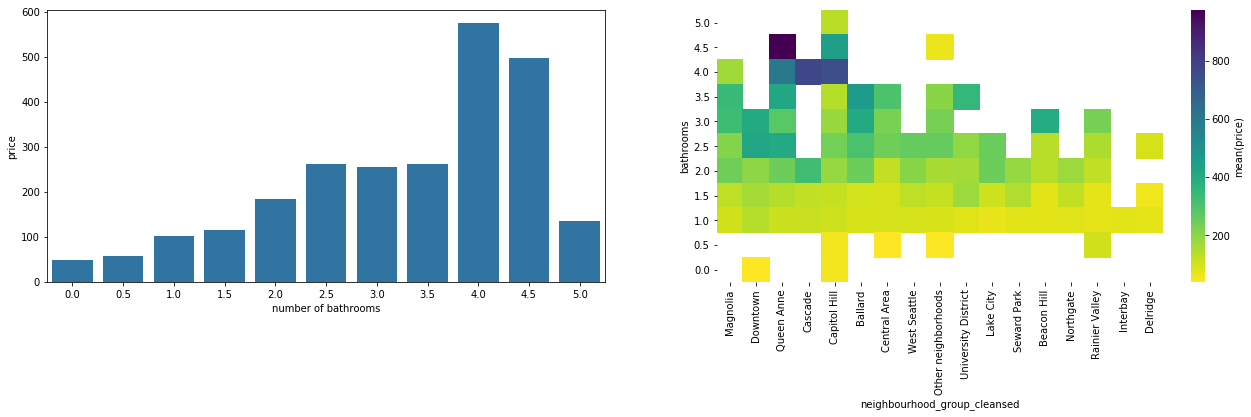

In [327]:

# plot the average price group by number of bathrooms
plt.figure(figsize = [22, 5])

plt.subplot(1,2,1)
df_plot_bathroom = df_neighborhood[['bathrooms','price' ]].copy()
df_plot_bathroom['bathrooms'] = df_plot_bathroom['bathrooms'].astype(str)
df_plot_bathroom = df_plot_bathroom[['bathrooms','price' ]].groupby(['bathrooms']).mean().sort_values(by = ['price'], ascending = False)
base_color = sns.color_palette()[0]
sns.barplot(x = df_plot_bathroom.index.values,y =  df_plot_bathroom['price'], color = base_color);
plt.xlabel('number of bathrooms');

# plot the average price group by number of bathrooms and neighbours
plt.subplot(1,2,2)

bathroom_level_order = df_neighborhood['bathrooms'].unique()
bathroom_level_order = np.absolute(np.sort(-bathroom_level_order)).astype(str)
ordered_cat_bathroom = pd.api.types.CategoricalDtype(ordered = True, categories = bathroom_level_order)

df_temp_03 = df_neighborhood.copy()

df_temp_03['bathrooms'] = df_temp_03['bathrooms'].astype(str).astype(ordered_cat_bathroom)
df_temp_03['neighbourhood_group_cleansed'] = df_temp_03['neighbourhood_group_cleansed'].astype(ordered_cat_neigh)
cat_means = df_temp_03.groupby(['neighbourhood_group_cleansed',  'bathrooms']).mean()['price']
cat_means = cat_means.reset_index(name = 'price_avg')
cat_means = cat_means.pivot(index = 'bathrooms', columns = 'neighbourhood_group_cleansed',
                            values = 'price_avg')
sns.heatmap(cat_means, annot = False, fmt = '.3f',cmap = 'viridis_r', cbar_kws = {'label' : 'mean(price)'})
plt.yticks(rotation=0);

### Qn2  What contributies a good rating of a listing

In this part, we will apply classifier algorithim.
We will use the same data set after step 1
Before applying the model, we will perform below procedure:

- Given the most half of 'review_scores_rating' is larger than 96, we transform 'review_scores_rating' from quantitative data to categorical data:
   - good rating, Above 96:       1
   - not good rating Below 96:       0 
- Drop the redundant columns
- Get the dummy variables for categorical data

In [328]:
df_q2 = df_minmax_transform.copy()
df_q2['review_scores_rating'][df_q2['review_scores_rating'] < 96] = 0
df_q2['review_scores_rating'][df_q2['review_scores_rating'] >= 96] = 1


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [329]:
# for below cols, since most rows are larger than 9, we transfor them into dummy variables
# for score larger than 9, is 1
# for score smaller than 9, is 0
df_q2_clean_other_score = df_q2.copy()
review_scores = ['review_scores_checkin','review_scores_communication','review_scores_value','review_scores_cleanliness', 'review_scores_accuracy','review_scores_location']
for col in review_scores:
    df_q2_clean_other_score[col][df_q2_clean_other_score[col] <= 9] = 0
    df_q2_clean_other_score[col][df_q2_clean_other_score[col] > 9] = 1


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [330]:
# below cols are redundant for classifying rating

df_q2_drop_col = df_q2_clean_other_score.drop(['host_location','host_verifications',
                                               'smart_location','latitude','longitude',
                                               'na_count'], axis = 1)

# Create dummy columns for all the categorical variables, drop the original columns
df_q2_final = pd.get_dummies(df_q2_drop_col)

In [331]:
# split the data into features and target lable
df_q2_features = df_q2_final.drop('review_scores_rating', axis = 1)
rating = df_q2_final['review_scores_rating']

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_q2_features, 
                                                    rating, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1784 samples.
Testing set has 446 samples.


In [332]:
def train_predict_q2(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: rating training set
       - X_test: features testing set
       - y_test: rating testing set
    Outputs:
       - result: score metrics
    
    '''
    
    results = {}
    
    # fit the learner to the trianing  data using slicing with 'sample_size'
    start = time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    # calculte the sample training time
    results['train_time'] = end - start
    
    # Get the predictions on the test set X_test
    pred_test = learner.predict(X_test)
    
    # Compuate the accuracy on test set
    results['acc_test'] = accuracy_score(y_test, pred_test)
    
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, pred_test, beta = 0.5)
    
    # Success
    print("{} trained on {} samples".format(learner.__class__.__name__, sample_size))
    
    # return the result
    return results
    

### Model Evaluation

In this part, we select three models:

- Naive Bayes
- Decision Tree
- Random Forest

We will train and test the model and calcuate the performance metrics: accuracy and fbeta_score.

And we will select best model based on above performance metrics.

In [333]:
# Initialize the three modesl
clf_NB = MultinomialNB()
clf_DT = DecisionTreeClassifier()
clf_RF = RandomForestClassifier()

results = {}
for clf in [clf_NB, clf_DT, clf_RF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict_q2(clf, len(y_train), X_train, y_train,
                                        X_test, y_test)
    print("{}\n-----".format(clf_name))
    print("accuracy on testing data:{:.4f}".format(results[clf_name]['acc_test']))
    print("F-score on testing data:{:.4f}".format(results[clf_name]['f_test']))
    


MultinomialNB trained on 1784 samples
MultinomialNB
-----
accuracy on testing data:0.5897
F-score on testing data:0.6401
DecisionTreeClassifier trained on 1784 samples
DecisionTreeClassifier
-----
accuracy on testing data:0.7444
F-score on testing data:0.7776
RandomForestClassifier trained on 1784 samples
RandomForestClassifier
-----
accuracy on testing data:0.7870
F-score on testing data:0.8203


Based on evaluation result accuracy and F-score, Random Forest Classifier would be the most appropriate model. 

Implemenition: Model Tuning

In this part, we are using grid search to find the optimal model in terms of f-score by selecting different paramters.

In [334]:
# Initialize the classifier we have choosed from above
clf_q2 = RandomForestClassifier()

# Create a dictionary of parameters to tune the choosen model
parameters = {'max_depth':[None,1,2,3,4],'min_samples_leaf':[1,2,3,4,5],
             'min_samples_split':[2,3,4,5,6]}

# make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta = 0.5);

# Perform grid search on the classifier using 'scorer' as the sorting method
grid_obj = GridSearchCV(clf_q2,parameters, scoring = scorer);

# Fit the grid search object to the training data and find the optiaml parameter
grid_fit = grid_obj.fit(X_train, y_train);

# Get the estimator
best_clf = grid_fit.best_estimator_;

# Fit the new model
best_clf.fit(X_train, y_train);

# make prediction using the new model
best_predictions = best_clf.predict(X_test);

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data:{:.4f}".format(results['DecisionTreeClassifier']['acc_test']))
print("F-score on testing data:{:.4f}".format(results['DecisionTreeClassifier']['f_test']))
print('\nOptimized Model\n------')
print("Final accuracy score on testing dataset:{:.4f}".format(accuracy_score(y_test,best_predictions)))
print("Final F-score on testing dataset:{:.4f}".format(fbeta_score(y_test,best_predictions,beta = 0.5)))


Unoptimized model
------
Accuracy score on testing data:0.7444
F-score on testing data:0.7776

Optimized Model
------
Final accuracy score on testing dataset:0.7758
Final F-score on testing dataset:0.7991


### Feature Relevance Observation

In [347]:
# insert income into features
feature_and_rating = df_q2_features
feature_and_rating['rating'] = rating
# calcualte the correlation between features and income
corr_matrix = feature_and_rating.corr()
# get the correlations between income and each features and sort in descending order
corr_rating = corr_matrix['rating'].sort_values(ascending=False)
print(corr_rating[-3:])

first_review_days                                  -0.099621
neighbourhood_group_cleansed_University District   -0.100435
calculated_host_listings_count                     -0.178536
Name: rating, dtype: float64


In [336]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7758
F-score on testing data: 0.7991

Final Model trained on reduced data
------
Accuracy on testing data: 0.8027
F-score on testing data: 0.8340


In [339]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation = 45)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()
    
# Above function is taking from the script 'visuals.py' from Udacity. Linked is below:
# https://viewe4e52e30.udacity-student-workspaces.com/edit/visuals.py

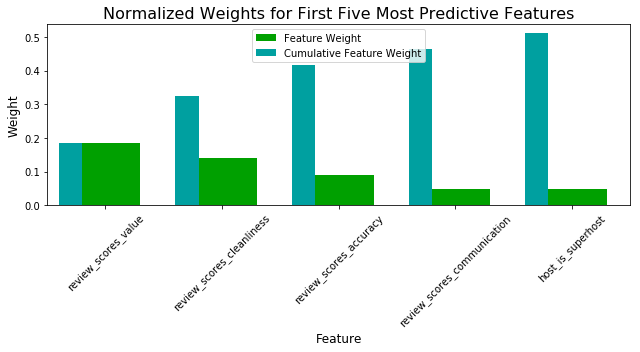

In [338]:
feature_plot(importances, X_train, y_train)

### Step 3 Select, Re-Encode Features and implement models for the third question

Based on above features, we will try to answer the second questions

- How does the price fluctate acrossing time?

In this part, we will use the  data set 'calendar and listing. 
We will:

- use listing_id as key to find review_scores_rating from dataset 'listing'
- calcualte the daily average price, daily number of listing  and daily average review scores
- plot above features acrossing time and analysis


In [291]:
# drop the listing which is not avaliable
df_q3 = calendar_01.dropna(axis = 0)

# transfer the price to number instead of string
df_q3['price'] = df_q3['price'].replace('[\$,]','', regex = True).astype(float)

# replace the 't/f' to 1/0
df_q3['available'].replace('t',1, inplace = True)
df_q3['available'].replace('f',0, inplace = True)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [292]:
df_q3_merge = df_q3.merge(listings[['id','review_scores_rating']], left_on = 'listing_id', right_on = 'id')
df_q3_final = df_q3_merge.drop(['id'],axis = 1)

In [293]:

# calucate the average price, number of avaliable listings, and review_scores on each day
df_q3_daily = pd.DataFrame(df_q3_final.groupby(['date'])['price'].mean())
df_q3_daily['number_of_listings'] = df_q3_final.groupby(['date'])['available'].sum()
df_q3_daily['rating'] = df_q3_final.groupby(['date'])['review_scores_rating'].mean()
df_q3_daily = df_q3_daily.rename(index = str, columns = {"price":"avg_price"})

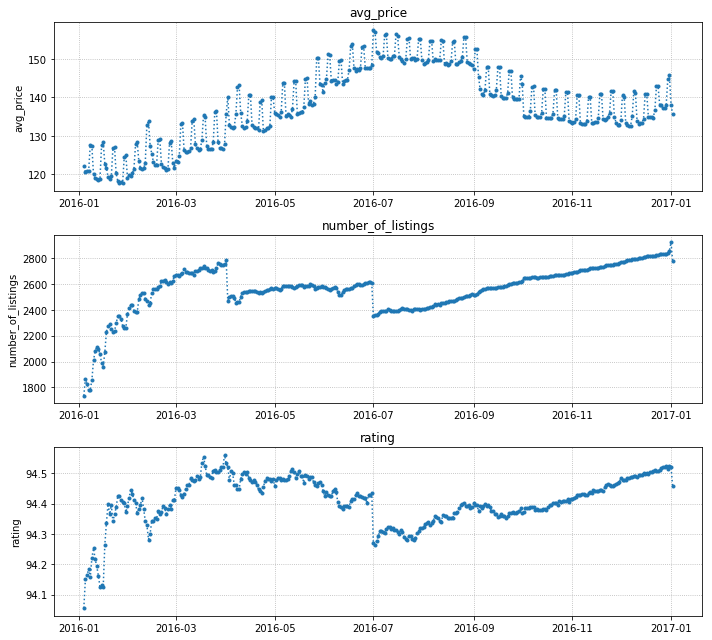

In [294]:
# plot the average price, number of listings and ratings acrossing the whole year 2016

idx = pd.date_range(min(df_q3_daily.index.values),max(df_q3_daily.index.values))
cols_plot = ['avg_price','number_of_listings','rating']
markers = ['']

fig = plt.figure(figsize=(10, 9))
for i,col in enumerate(cols_plot):
    ax = plt.subplot(3,1,i+1)
    ax.plot_date(idx.to_pydatetime(),df_q3_daily[col],marker = ".",linestyle=':')
    ax.set_title(col)
    ax.set_ylabel(col)
    ax.grid(linestyle=':')

plt.tight_layout()

plt.show()